In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import scipy.stats
import tbapy

tba = tbapy.TBA('b6p0KPExEdkWjOcCyu8araEQQDfNn66RXCQVQdex4H1xH3yLlO8wwSd0iHzCi0FG')

In [2]:
def calc_ema(data: np.ndarray, alpha: float) -> float:
    if len(data) == 1:
        return data[0]
    
    return alpha * data[len(data)-1] + (1 - alpha) * calc_ema(np.resize(data, len(data)-1), alpha)

In [3]:
team_data = pd.DataFrame({'team_key': pd.Series(dtype=str), 'contributed_points': pd.Series(dtype=np.ndarray([], dtype=float)), 'match_numbers': pd.Series(dtype=np.ndarray([], dtype=float))})
team_data = team_data.set_index("team_key")

match_csv = pd.read_csv('-.csv')

for index, row in match_csv.iterrows():
    if not row.team_key in team_data.index:
        team_data.loc[row.team_key] = [np.array([], dtype=float), np.array([], dtype=int)]
    
    team = team_data.loc[row.team_key]
    team.contributed_points = np.append(team.contributed_points, int(row.contributedPoints))
    team.match_numbers = np.append(team.match_numbers, int(row.match_number))



In [4]:
match_data = pd.DataFrame({'match_number': pd.Series(dtype=int), 'red_alliance': pd.Series(dtype=np.ndarray([], dtype=str)), 'blue_alliance': pd.Series(dtype=np.ndarray([], dtype=str))})
match_data = match_data.set_index('match_number')

for index, row in match_csv.iterrows():
    if not row.match_number in match_data.index:
        match_data.loc[row.match_number] = [np.array([], dtype=str), np.array([], dtype=str)]
    
    match = match_data.loc[row.match_number]
    match[f"{row.alliance}_alliance"] = np.append(match[f"{row.alliance}_alliance"], row.team_key)


In [5]:
def get_match_prediction(match_num: int, alpha: float):
    if not match_num in match_data.index:
        return ['', -1]
    
    red_alliance = match_data.loc[match_num].red_alliance
    blue_alliance = match_data.loc[match_num].blue_alliance

    red_avgs = np.array([])
    red_stds = np.array([])
    blue_avgs = np.array([])
    blue_stds = np.array([])

    for key in red_alliance:
        team = team_data.loc[key]

        matches_played = len(team.match_numbers[team.match_numbers < match_num])

        if matches_played < 2:
            return

        points = np.resize(team.contributed_points, matches_played)

        red_avgs = np.append(red_avgs, calc_ema(points, alpha))
        red_stds = np.append(red_stds, points.std(ddof=1))
    
    for key in blue_alliance:
        team = team_data.loc[key]

        matches_played = len(team.match_numbers[team.match_numbers < match_num])

        if matches_played <= 2:
            return

        points = np.resize(team.contributed_points, matches_played)

        blue_avgs = np.append(blue_avgs, calc_ema(points, alpha))
        blue_stds = np.append(blue_stds, points.std(ddof=1))

    z_score = (red_avgs.sum() - blue_avgs.sum()) / math.hypot(red_stds.sum(), blue_stds.sum())
    p_val = scipy.stats.norm.cdf(z_score)

    if p_val < 0.5:
        return ['blue', 1-p_val]
    
    return ['red', p_val]

In [6]:
tba_winners = pd.DataFrame({'match_number': pd.Series(dtype=int), 'winner': pd.Series(dtype=str)})
tba_winners = tba_winners.set_index('match_number')

for i in range(1, len(match_data.index)+1):
    tba_winners.loc[i] = [tba.match(key=f'{match_csv.iloc[1].event_key}_qm{i}', simple=True).winning_alliance]

tba_winners

,winner
match_number,
1,red
2,red
3,red
4,blue
5,red
...,...
116,red
117,red
118,red


In [7]:
def get_prediction_accuracy(threshold: float = 0.0, alpha: float = 0.4):
    results = np.array([])

    for i in range(1, len(match_data.index)+1):
        check = True
        prediction = get_match_prediction(i, alpha)

        if prediction:
            check = tba_winners.loc[i].winner == prediction[0] 
            
            if prediction[1] >= threshold:
                results = np.append(results, check)
    
    return np.average(results)

c:\Users\Team102\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Team102\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


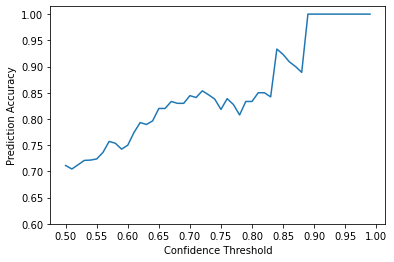

In [11]:
prediction_accuracy = pd.DataFrame({'threshold': pd.Series(dtype=float), 'accuracy': pd.Series(dtype=float)})

for i in range(0, 51):
    thresh = 0.50 + (i * 0.01)

    prediction_accuracy.loc[i] = [thresh, get_prediction_accuracy(thresh)]

fig, ax = plt.subplots()

ax.plot(prediction_accuracy.threshold, prediction_accuracy.accuracy)

ax.set(xticks=np.arange(0.5, 1.01, 0.05), yticks=np.arange(0.6, 1.01, 0.05), xlabel='Confidence Threshold', ylabel='Prediction Accuracy', title="")

fig.set_facecolor('xkcd:white')

plt.show()

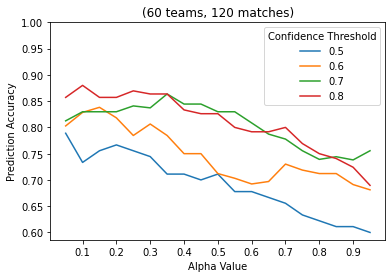

In [13]:
prediction_accuracy = pd.DataFrame({'alpha value': pd.Series(dtype=float), 'accuracy': pd.Series(dtype=float)})

def alpha_accuracy(df: pd.DataFrame, threshold: float):
    for i in range(1, 20):
        alph = i * 0.05

        df.loc[i] = [alph, get_prediction_accuracy(threshold, alph)]

fig, ax = plt.subplots()

for i in range(0, 4):
    thresh = 0.1 * i + 0.5

    alpha_accuracy(prediction_accuracy, thresh)

    ax.plot(prediction_accuracy['alpha value'], prediction_accuracy.accuracy, label=str(thresh))

ax.set(xticks=np.arange(0.1, 1.0, 0.1), yticks=np.arange(0.6, 1.01, 0.05), xlabel='Alpha Value', ylabel='Prediction Accuracy', title=f"({len(team_data.index)} teams, {len(match_data.index)} matches)")
ax.legend(title='Confidence Threshold')

fig.set_facecolor('xkcd:white')

plt.show()
